## Import necessary libraries

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2, MobileNetV2

# For class-balanced focal loss
import tensorflow.keras.backend as K

In [5]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## Download the dataset

In [6]:
# Download the dataset
import kagglehub
# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Path to dataset files:", path)

c:\Users\akhil\OneDrive\Desktop\Pneumonia App\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\akhil\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2


In [7]:
base_dir = path
train_dir = os.path.join(base_dir, 'chest_xray', 'train')
test_dir = os.path.join(base_dir, 'chest_xray', 'test')
val_dir = os.path.join(base_dir, 'chest_xray', 'val')

## Data Exploration - Count images

In [8]:
# Data Exploration - Count images
train_normal_count = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
train_pneumonia_count = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
test_normal_count = len(os.listdir(os.path.join(test_dir, 'NORMAL')))
test_pneumonia_count = len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))
val_normal_count = len(os.listdir(os.path.join(val_dir, 'NORMAL')))
val_pneumonia_count = len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))

In [9]:
print("\nDataset Structure:")
print(f"Training: NORMAL={train_normal_count}, PNEUMONIA={train_pneumonia_count}")
print(f"Testing: NORMAL={test_normal_count}, PNEUMONIA={test_pneumonia_count}")
print(f"Validation: NORMAL={val_normal_count}, PNEUMONIA={val_pneumonia_count}")


Dataset Structure:
Training: NORMAL=1341, PNEUMONIA=3875
Testing: NORMAL=234, PNEUMONIA=390
Validation: NORMAL=8, PNEUMONIA=8


## Calculate class imbalance and visualize

In [10]:
# Calculate class imbalance and visualize
total_normal = train_normal_count + test_normal_count + val_normal_count
total_pneumonia = train_pneumonia_count + test_pneumonia_count + val_pneumonia_count
imbalance_ratio = total_pneumonia / total_normal

In [11]:
print(f"\nClass Imbalance Analysis:")
print(f"Total NORMAL images: {total_normal}")
print(f"Total PNEUMONIA images: {total_pneumonia}")
print(f"Imbalance ratio (PNEUMONIA:NORMAL): {imbalance_ratio:.2f}")


Class Imbalance Analysis:
Total NORMAL images: 1583
Total PNEUMONIA images: 4273
Imbalance ratio (PNEUMONIA:NORMAL): 2.70


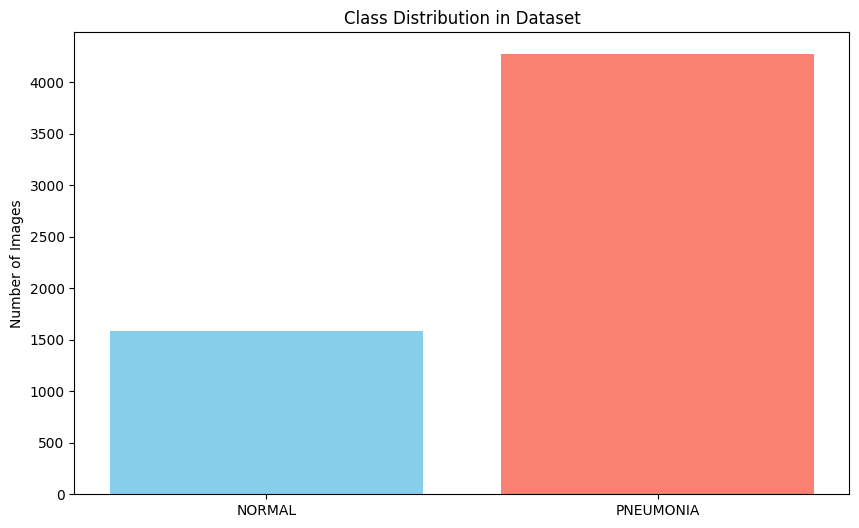

In [12]:
plt.figure(figsize=(10, 6))
plt.bar(['NORMAL', 'PNEUMONIA'], [total_normal, total_pneumonia], color=['skyblue', 'salmon'])
plt.title('Class Distribution in Dataset')
plt.ylabel('Number of Images')
plt.savefig('class_distribution.png')
plt.show()

Class: NORMAL


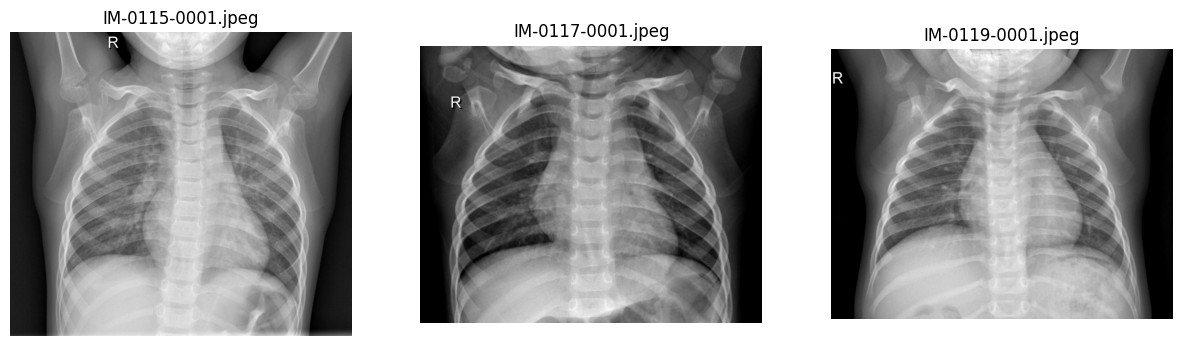

Class: PNEUMONIA


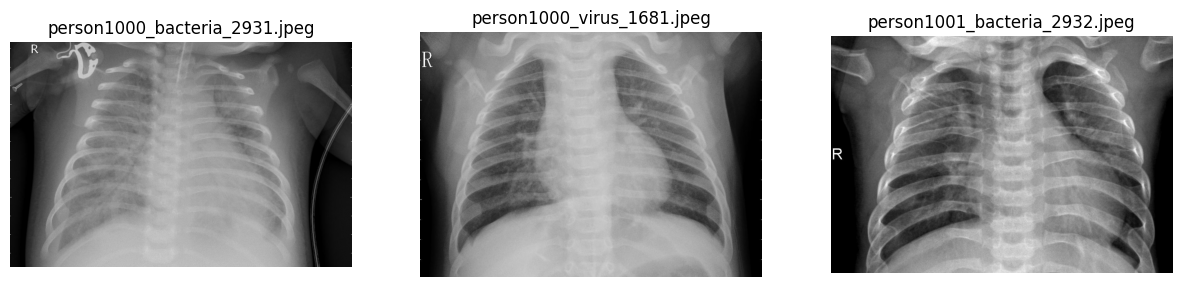

Class: NORMAL


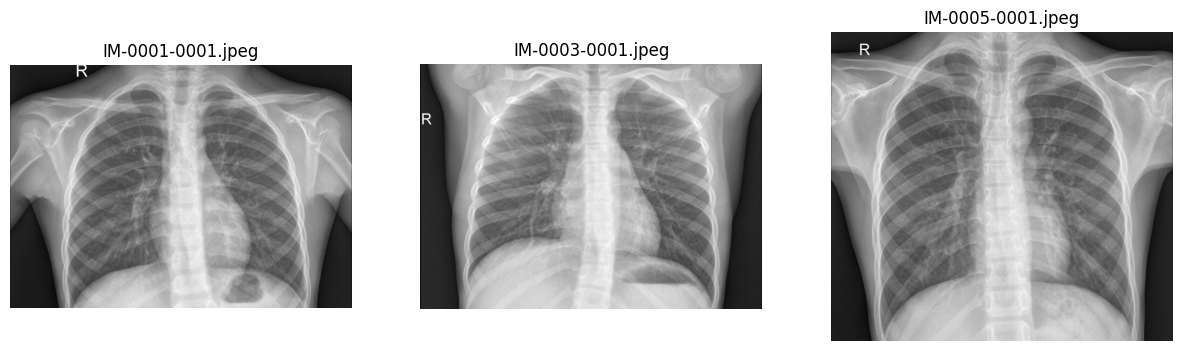

Class: PNEUMONIA


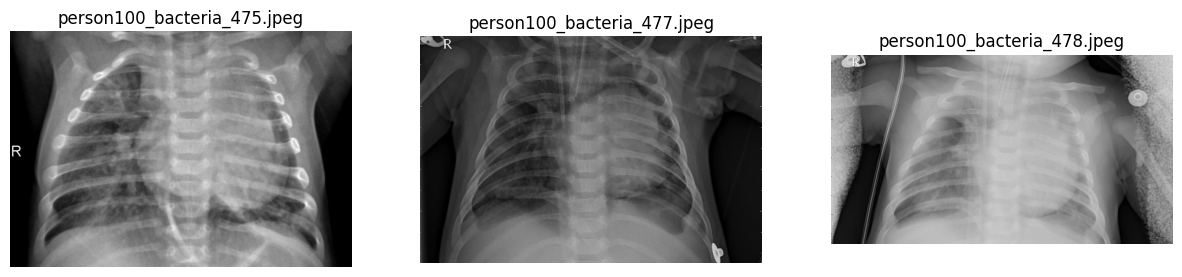

Class: NORMAL


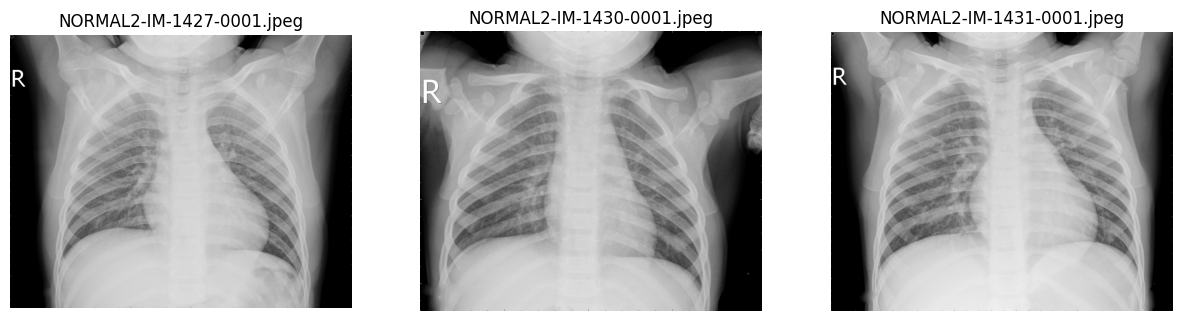

Class: PNEUMONIA


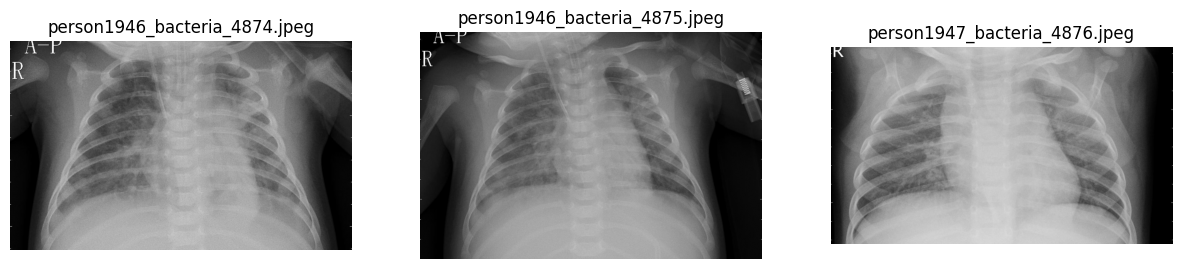

In [13]:
# prompt: write code to display sample imagas from all the classes

import matplotlib.pyplot as plt
import os

# Assuming train_dir, test_dir, val_dir are defined as in the previous code

def display_sample_images(directory, num_images=5):
    """Displays sample images from each class in a directory."""
    classes = os.listdir(directory)
    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            images = os.listdir(class_dir)[:num_images]  # Get first num_images
            print(f"Class: {class_name}")
            plt.figure(figsize=(15, 5))  # Adjust figure size as needed
            for i, image_name in enumerate(images):
                image_path = os.path.join(class_dir, image_name)
                img = plt.imread(image_path)
                plt.subplot(1, num_images, i + 1)
                plt.imshow(img, cmap='gray') # Use 'gray' for grayscale images
                plt.title(image_name)
                plt.axis('off')
            plt.show()

# Example usage: Display 3 sample images from each class in the training directory
display_sample_images(train_dir, num_images=3)
display_sample_images(test_dir, num_images=3)
display_sample_images(val_dir, num_images=3)


## Implement balanced data sampling for training


In [14]:
# Create a more balanced training set by undersampling the majority class
# and applying more augmentation to the minority class

# First, let's undersample the majority class (PNEUMONIA) to reduce imbalance
normal_count = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
pneumonia_count = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))


In [15]:
print(f"Original training distribution: NORMAL={normal_count}, PNEUMONIA={pneumonia_count}")

Original training distribution: NORMAL=1341, PNEUMONIA=3875


In [16]:
# Define the target ratio (not completely balanced, but less imbalanced)
target_ratio = 1.5  # pneumonia:normal ratio

# Calculate how many pneumonia samples to keep
target_pneumonia_count = int(normal_count * target_ratio)

In [17]:
if pneumonia_count > target_pneumonia_count:
    # Get all pneumonia files
    pneumonia_files = os.listdir(os.path.join(train_dir, 'PNEUMONIA'))

    # Randomly select files to keep
    np.random.seed(42)  # For reproducibility
    selected_pneumonia_files = np.random.choice(
        pneumonia_files,
        size=target_pneumonia_count,
        replace=False
    )

    # Create a directory for the balanced dataset in /kaggle/working
    balanced_dir = os.path.join(os.getcwd(), 'balanced_train')

    os.makedirs(balanced_dir, exist_ok=True)
    os.makedirs(os.path.join(balanced_dir, 'NORMAL'), exist_ok=True)
    os.makedirs(os.path.join(balanced_dir, 'PNEUMONIA'), exist_ok=True)

    # Copy NORMAL files
    import shutil
    for file in os.listdir(os.path.join(train_dir, 'NORMAL')):
        shutil.copy(
            os.path.join(train_dir, 'NORMAL', file),
            os.path.join(balanced_dir, 'NORMAL', file)
        )

    # Copy selected PNEUMONIA files
    for file in selected_pneumonia_files:
        shutil.copy(
            os.path.join(train_dir, 'PNEUMONIA', file),
            os.path.join(balanced_dir, 'PNEUMONIA', file)
        )

    print(f"Created balanced training set: NORMAL={normal_count}, PNEUMONIA={target_pneumonia_count}")
    print(f"Reduced imbalance ratio from {pneumonia_count/normal_count:.2f} to {target_ratio:.2f}")

    # Update the training directory to use the balanced set
    train_dir = balanced_dir
else:
    print("No undersampling needed, imbalance ratio is acceptable.")

Created balanced training set: NORMAL=1341, PNEUMONIA=2011
Reduced imbalance ratio from 2.89 to 1.50


## Cell 7: Create a validation split from the training data

In [18]:
# Create a validation split from the training data
from sklearn.model_selection import train_test_split

# Get all training image paths
normal_train_paths = [os.path.join(train_dir, 'NORMAL', f) for f in os.listdir(os.path.join(train_dir, 'NORMAL'))]
pneumonia_train_paths = [os.path.join(train_dir, 'PNEUMONIA', f) for f in os.listdir(os.path.join(train_dir, 'PNEUMONIA'))]

In [19]:
# Split training data to create a validation split (20% of training)
normal_train_files, normal_val_files = train_test_split(normal_train_paths, test_size=0.2, random_state=42)
pneumonia_train_files, pneumonia_val_files = train_test_split(pneumonia_train_paths, test_size=0.2, random_state=42)

In [20]:
# Create dataframes for the generators
train_df = pd.DataFrame({
    'filename': normal_train_files + pneumonia_train_files,
    'class': ['NORMAL'] * len(normal_train_files) + ['PNEUMONIA'] * len(pneumonia_train_files)
})

val_df = pd.DataFrame({
    'filename': normal_val_files + pneumonia_val_files,
    'class': ['NORMAL'] * len(normal_val_files) + ['PNEUMONIA'] * len(pneumonia_val_files)
})

test_df = pd.DataFrame({
    'filename': [os.path.join(test_dir, 'NORMAL', f) for f in os.listdir(os.path.join(test_dir, 'NORMAL'))] +
                [os.path.join(test_dir, 'PNEUMONIA', f) for f in os.listdir(os.path.join(test_dir, 'PNEUMONIA'))],
    'class': ['NORMAL'] * test_normal_count + ['PNEUMONIA'] * test_pneumonia_count
})


In [21]:
# Print the new split sizes
print(f"New split - Training: {len(train_df)} images ({train_df['class'].value_counts().to_dict()})")
print(f"Validation: {len(val_df)} images ({val_df['class'].value_counts().to_dict()})")
print(f"Testing: {len(test_df)} images ({test_df['class'].value_counts().to_dict()})")

New split - Training: 2680 images ({'PNEUMONIA': 1608, 'NORMAL': 1072})
Validation: 672 images ({'PNEUMONIA': 403, 'NORMAL': 269})
Testing: 624 images ({'PNEUMONIA': 390, 'NORMAL': 234})


## Implement a balanced batch generator

In [22]:
# Implement a balanced batch generator
class BalancedDataGenerator:
    def __init__(self, dataframe, x_col, y_col, classes, batch_size=32, target_size=(224, 224),
                 shuffle=True, augmentation=False):
        self.dataframe = dataframe
        self.x_col = x_col
        self.y_col = y_col
        self.classes = classes
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.augmentation = augmentation

        # Split dataframe by class
        self.df_by_class = {cls: self.dataframe[self.dataframe[y_col] == cls] for cls in classes}

        # Define augmentation settings if enabled
        if self.augmentation:
            self.datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )
        else:
            self.datagen = ImageDataGenerator(rescale=1./255)

        # Calculate size
        self.smallest_class_size = min([len(df) for df in self.df_by_class.values()])
        self.samples_per_class = self.batch_size // len(classes)

    def __len__(self):
        """Number of batches per epoch"""
        return int(np.ceil(self.smallest_class_size / self.samples_per_class))

    def __iter__(self):
        return self

    def __next__(self):
        batch_x = []
        batch_y = []

        # For each class, select samples_per_class samples
        for cls, cls_df in self.df_by_class.items():
            # If shuffle enabled, randomly select files
            if self.shuffle:
                samples = cls_df.sample(self.samples_per_class, replace=len(cls_df) < self.samples_per_class)
            else:
                # Without shuffle, we need to track position
                if not hasattr(self, 'indices'):
                    self.indices = {cls: 0 for cls in self.classes}

                start_idx = self.indices[cls]
                end_idx = min(start_idx + self.samples_per_class, len(cls_df))
                if end_idx - start_idx < self.samples_per_class:
                    # Wrap around if needed
                    samples1 = cls_df.iloc[start_idx:end_idx]
                    samples2 = cls_df.iloc[:self.samples_per_class - (end_idx - start_idx)]
                    samples = pd.concat([samples1, samples2])
                    self.indices[cls] = self.samples_per_class - (end_idx - start_idx)
                else:
                    samples = cls_df.iloc[start_idx:end_idx]
                    self.indices[cls] = end_idx % len(cls_df)

            # Load and preprocess images
            for _, row in samples.iterrows():
                img_path = row[self.x_col]
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=self.target_size)
                img_array = tf.keras.preprocessing.image.img_to_array(img)

                # Apply preprocessing
                img_array = img_array / 255.0

                batch_x.append(img_array)
                # Convert class to numeric
                batch_y.append(1 if row[self.y_col] == 'PNEUMONIA' else 0)

        # Convert lists to arrays
        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)

        # Apply augmentation if enabled
        if self.augmentation:
            # Apply augmentation to the batch
            for i in range(len(batch_x)):
                if np.random.rand() < 0.5:  # Apply augmentation to 50% of images
                    params = self.datagen.get_random_transform(batch_x[i].shape)
                    batch_x[i] = self.datagen.apply_transform(batch_x[i], params)

        return batch_x, batch_y

    def make_infinite(self):
        """Creates an infinite generator"""
        while True:
            yield next(self)

##Cell 9: Create balanced data generators

In [27]:
# Create balanced data generators
img_width, img_height = 224, 224
batch_size = 32

In [28]:
# Create balanced generators
train_generator = BalancedDataGenerator(
    train_df, 'filename', 'class',
    classes=['NORMAL', 'PNEUMONIA'],
    batch_size=batch_size,
    target_size=(img_width, img_height),
    shuffle=True,
    augmentation=True
).make_infinite()

val_generator = BalancedDataGenerator(
    val_df, 'filename', 'class',
    classes=['NORMAL', 'PNEUMONIA'],
    batch_size=batch_size,
    target_size=(img_width, img_height),
    shuffle=False,
    augmentation=False
).make_infinite()

In [29]:
# For test, we'll use the standard generator to get true class distribution
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='class',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    classes={'NORMAL': 0, 'PNEUMONIA': 1},
    shuffle=False
)

Found 624 validated image filenames belonging to 2 classes.


## Cell 10: Implement Focal Loss for better handling of class imbalance

In [30]:
# Implement Focal Loss for better handling of class imbalance
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1 + K.epsilon())) - \
               K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed

## Cell 11: Build a better model using transfer learning

In [31]:
# Build a better model using transfer learning
# Option 2: Transfer learning with MobileNetV2 (lighter, faster)
def build_mobilenet_model(img_width=224, img_height=224):
    base_model = MobileNetV2(weights='imagenet', include_top=False,
                          input_shape=(img_width, img_height, 3))

    # Freeze the base model
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    return model

## Cell 12: Select and compile the model - Let's use the MobileNet model for efficiency

In [32]:
# Select and compile the model - Let's use the MobileNet model for efficiency
model = build_mobilenet_model(img_width, img_height)

# Compile with focal loss
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=focal_loss(gamma=2.0, alpha=0.25),  # Focal loss for handling imbalance
    metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,201 (9.87 MB)

 Trainable params: 328,705 (1.25 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

## Cell 13: Set up callbacks for training

In [33]:
# Set up callbacks for training
checkpoint = ModelCheckpoint(
    'best_pneumonia_model.h5',
    monitor='val_auc',  # Monitor AUC instead of accuracy
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

In [34]:
# Calculate steps_per_epoch and validation_steps
steps_per_epoch = min(len(train_df) // batch_size, 100)  # Limit to 100 steps max
validation_steps = min(len(val_df) // batch_size, 50)    # Limit to 50 steps max

In [35]:
# Ensure at least 1 step
steps_per_epoch = max(1, steps_per_epoch)
validation_steps = max(1, validation_steps)

In [36]:
print(f"Training with {steps_per_epoch} steps per epoch and {validation_steps} validation steps")

Training with 83 steps per epoch and 21 validation steps


## Cell 14: Train the model

In [37]:
# Two-Phase Training Approach
# Phase 1: Train with frozen base model
print("Phase 1: Training with frozen base model...")
history1 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=5,  # First 5 epochs with frozen base model
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1
)

Phase 1: Training with frozen base model...
Epoch 1/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7029 - auc: 0.7725 - loss: 0.1431 - precision: 0.7105 - recall: 0.6865
Epoch 1: val_auc improved from -inf to 0.97519, saving model to best_pneumonia_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.7040 - auc: 0.7738 - loss: 0.1424 - precision: 0.7117 - recall: 0.6876 - val_accuracy: 0.9271 - val_auc: 0.9752 - val_loss: 0.0236 - val_precision: 0.9644 - val_recall: 0.8869 - learning_rate: 1.0000e-04
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8795 - auc: 0.9459 - loss: 0.0558 - precision: 0.9106 - recall: 0.8421
Epoch 2: val_auc improved from 0.97519 to 0.97952, saving model to best_pneumonia_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.8795 - auc: 0.9460 - loss: 0.0556 - precision: 0.9107 - recall: 0.8421 - val_accuracy: 0.9315 - val_auc: 0.9795 - val_loss: 0.0225 - val_precision: 0.9677 - val_recall: 0.8929 - learning_rate: 1.0000e-04
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.8983 - auc: 0.9600 - loss: 0.0437 - precision: 0.9461 - recall: 0.8448
Epoch 3: val_auc improved from 0.97952 to 0.98735, saving model to best_pneumonia_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 48s 585ms/step - accuracy: 0.8984 - auc: 0.9600 - loss: 0.0436 - precision: 0.9461 - recall: 0.8449 - val_accuracy: 0.9509 - val_auc: 0.9874 - val_loss: 0.0191 - val_precision: 0.9779 - val_recall: 0.9226 - learning_rate: 1.0000e-04
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.9133 - auc: 0.9783 - loss: 0.0270 - precision: 0.9536 - recall: 0.8690
Epoch 4: val_auc did not improve from 0.98735
83/83 ━━━━━━━━━━━━━━━━━━━━ 46s 561ms/step - accuracy: 0.9133 - auc: 0.9783 - loss: 0.0271 - precision: 0.9536 - recall: 0.8690 - val_accuracy: 0.9568 - val_auc: 0.9871 - val_loss: 0.0211 - val_precision: 0.9752 - val_recall: 0.9375 - learning_rate: 1.0000e-04
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.9362 - auc: 0.9800 - loss: 0.0252 - precision: 0.9674 - recall: 0.9027
Epoch 5: val_auc improved from 0.98735 to 0.98932, saving model to best_pneumonia_model.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 51s 620ms/step - accuracy: 0.9361 - auc: 0.9799 - loss: 0.0252 - precision: 0.9674 - recall: 0.9026 - val_accuracy: 0.9598 - val_auc: 0.9893 - val_loss: 0.0177 - val_precision: 0.9843 - val_recall: 0.9345 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 5.


In [38]:
# Phase 2: Unfreeze base model and train with lower learning rate
print("Phase 2: Fine-tuning with unfrozen base model...")
# Unfreeze the base model
base_model = model.layers[0]
base_model.trainable = True

Phase 2: Fine-tuning with unfrozen base model...


In [39]:
# Recompile the model with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


In [40]:
# Continue training with unfrozen base model
history2 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,  # Additional epochs for fine-tuning
    initial_epoch=5,  # Start from epoch 5
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1
)

Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.7385 - auc_1: 0.8039 - loss: 0.1385 - precision_1: 0.7477 - recall_1: 0.7224 - val_accuracy: 0.8884 - val_auc_1: 0.9843 - val_loss: 0.1093 - val_precision_1: 0.8222 - val_recall_1: 0.9911 - learning_rate: 1.0000e-05
Epoch 7/10


c:\Users\akhil\OneDrive\Desktop\Pneumonia App\venv\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:209: UserWarning: Can save best model only with val_auc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.8473 - auc_1: 0.9265 - loss: 0.0671 - precision_1: 0.8704 - recall_1: 0.8164 - val_accuracy: 0.7545 - val_auc_1: 0.9821 - val_loss: 0.2221 - val_precision_1: 0.6713 - val_recall_1: 0.9970 - learning_rate: 1.0000e-05
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.8802 - auc_1: 0.9461 - loss: 0.0578 - precision_1: 0.9091 - recall_1: 0.8454 - val_accuracy: 0.7917 - val_auc_1: 0.9745 - val_loss: 0.2051 - val_precision_1: 0.7076 - val_recall_1: 0.9940 - learning_rate: 1.0000e-05
Epoch 9/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.8918 - auc_1: 0.9524 - loss: 0.0559 - precision_1: 0.9173 - recall_1: 0.8616 - val_accuracy: 0.8065 - val_auc_1: 0.9729 - val_loss: 0.1963 - val_precision_1: 0.7259 - val_recall_1: 0.9851 - learning_rate: 1.0000e-05
Epoch 10/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.9153 - auc_1: 0.9732 - loss: 0.0360 - precision_1: 0.9519 - recall_1: 0.8749 - val_accuracy: 0.8244 - 

## Cell 15: Plot training history

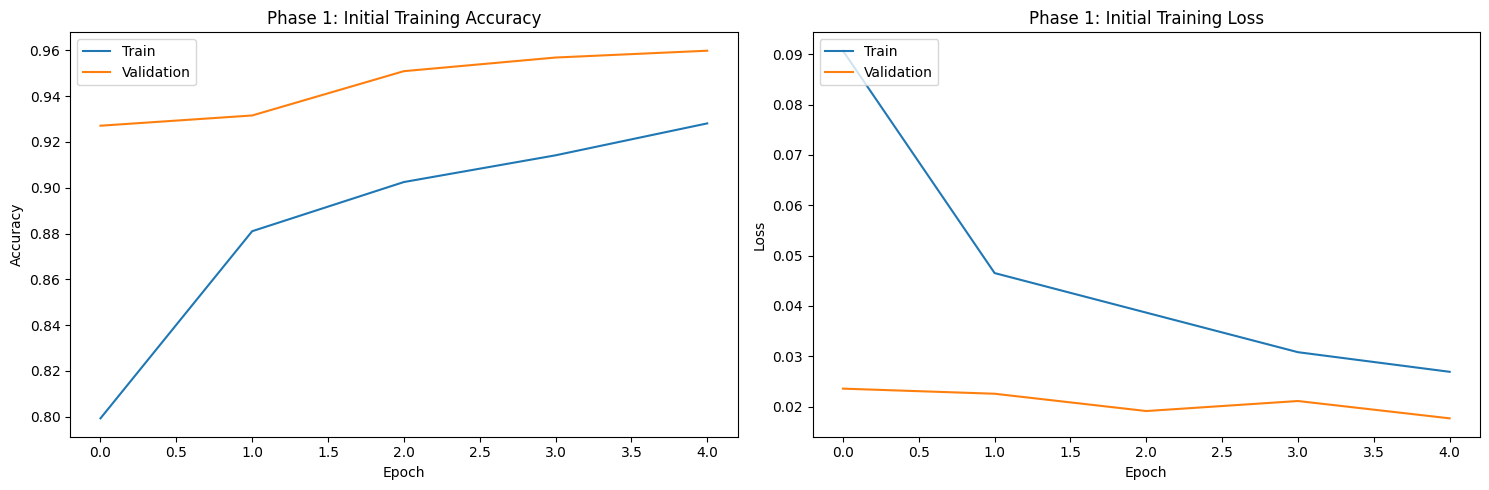

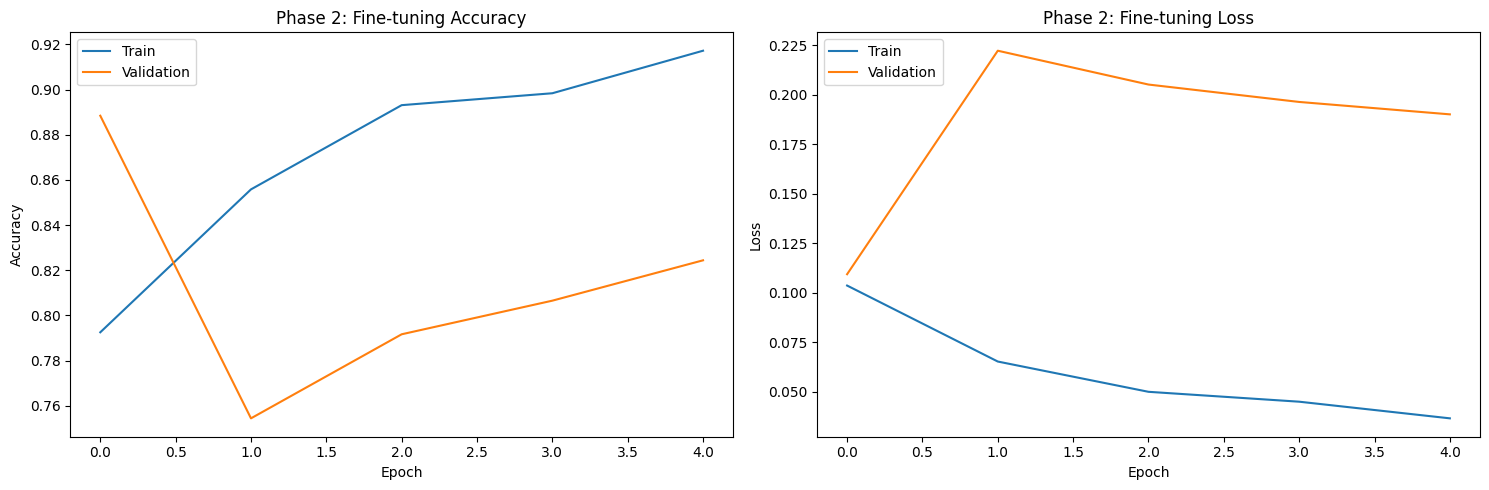

In [41]:
# Plot separate training histories instead of combining them
# Plot Phase 1
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Phase 1: Initial Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Phase 1: Initial Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('phase1_training_history.png')
plt.show()

# Plot Phase 2
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Phase 2: Fine-tuning Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Phase 2: Fine-tuning Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('phase2_training_history.png')
plt.show()

In [42]:
# Load the best model for evaluation
def get_custom_objects():
    """Return the custom objects dictionary for model loading"""
    return {'focal_loss_fixed': focal_loss(gamma=2.0, alpha=0.25)}

## Cell 16: Load the best model for evaluation

In [43]:
# Load best model
print("Loading best model for evaluation...")
if os.path.exists('best_pneumonia_model.h5'):
    print("Loading best saved model from checkpoint file...")
    try:
        best_model = load_model('best_pneumonia_model.h5', custom_objects=get_custom_objects())
        print("Successfully loaded best model from checkpoint")
    except Exception as e:
        print(f"Error loading best model: {e}")
        print("Using current model instead.")
        best_model = model
else:
    # If early stopping triggered, the best weights should be in the current model
    print("Best model file not found. Using the current model with best weights from early stopping.")
    best_model = model

# Save best model file explicitly in case it wasn't saved during training
best_model.save('best_pneumonia_model_final.h5', save_format='h5')
print("Best model saved as best_pneumonia_model_final.h5")

Loading best model for evaluation...
Loading best saved model from checkpoint file...


Successfully loaded best model from checkpoint
Best model saved as best_pneumonia_model_final.h5


## Cell 17: Evaluate the model on test data

In [44]:
# Evaluate the model on test data
test_steps = test_generator.samples // batch_size
test_steps = max(1, test_steps)  # Ensure at least 1 step

test_results = best_model.evaluate(test_generator, steps=test_steps)
print("\nEvaluation Results:")
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])
print("Test AUC:", test_results[2])
print("Test Precision:", test_results[3])
print("Test Recall:", test_results[4])

c:\Users\akhil\OneDrive\Desktop\Pneumonia App\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 315ms/step - accuracy: 0.8530 - auc: 0.6255 - loss: 0.0892 - precision: 0.4824 - recall: 0.6143

Evaluation Results:
Test Loss: 0.05687994137406349
Test Accuracy: 0.8881579041481018
Test AUC: 0.9634124040603638
Test Precision: 0.8805969953536987
Test Recall: 0.9465240836143494


## Cell 18: Generate predictions and confusion matrix

In [45]:
# Get actual labels
y_true = test_generator.classes

# Reset the test generator to ensure we get predictions for all samples
test_generator.reset()

# Calculate the correct number of steps to cover all samples
test_steps = int(np.ceil(test_generator.samples / batch_size))

In [46]:
# Get predictions with enough steps to cover all samples
print("Generating predictions...")
y_pred_prob = best_model.predict(test_generator, steps=test_steps)

Generating predictions...
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 347ms/step


In [47]:
# Trim predictions to match the exact number of samples
y_pred_prob = y_pred_prob[:test_generator.samples]
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

In [48]:
# Double-check lengths to make sure they match
print(f"Number of true labels: {len(y_true)}")
print(f"Number of predictions: {len(y_pred)}")

Number of true labels: 624
Number of predictions: 624


In [49]:
# Make sure both arrays have the same length before creating confusion matrix
if len(y_true) != len(y_pred):
    print(f"Warning: Lengths don't match. Trimming to the shorter length.")
    min_len = min(len(y_true), len(y_pred))
    y_true = y_true[:min_len]
    y_pred = y_pred[:min_len]

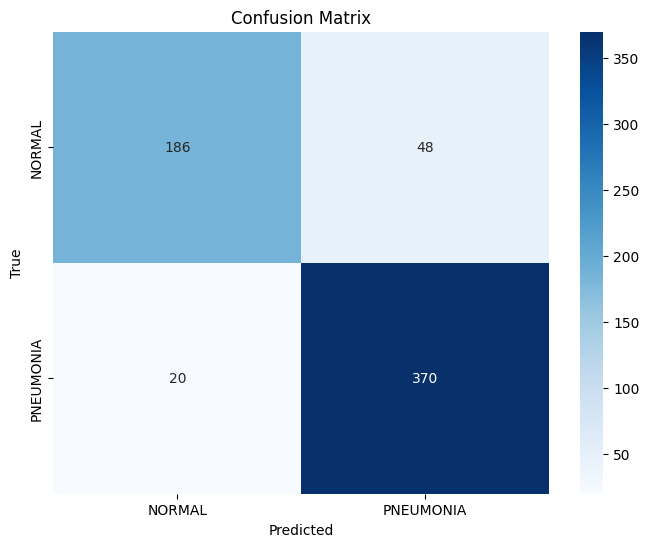

In [50]:
# Now create the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

## Cell 19: Print classification report with zero_division parameter

In [51]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA'], zero_division=0))


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.90      0.79      0.85       234
   PNEUMONIA       0.89      0.95      0.92       390

    accuracy                           0.89       624
   macro avg       0.89      0.87      0.88       624
weighted avg       0.89      0.89      0.89       624



## Cell 20: Plot ROC curve

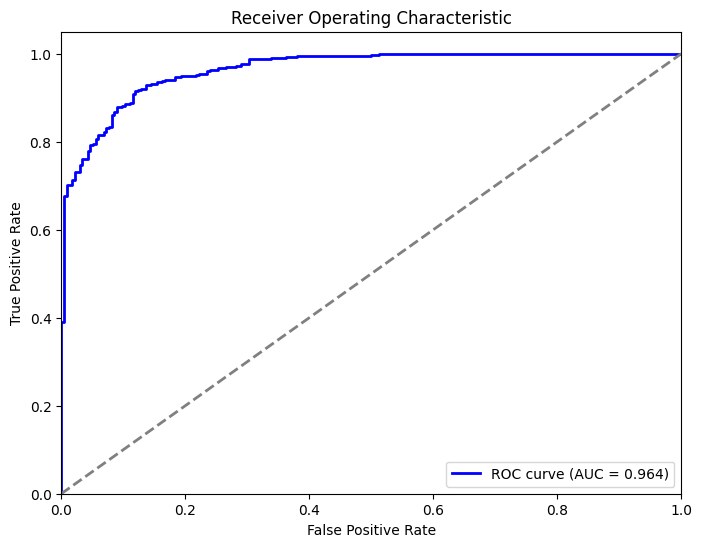

In [52]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()


## Cell 21: Create a model wrapper for Pickle export

In [53]:
# Create a model wrapper for Pickle export
class PneumoniaClassifier:
    def __init__(self, model):
        # Store the model directly
        self.model = model
        self.img_width = 224
        self.img_height = 224

    def preprocess_image(self, img_path):
        """Preprocess an image for prediction"""
        from tensorflow.keras.preprocessing.image import load_img, img_to_array
        img = load_img(img_path, target_size=(self.img_width, self.img_height))
        img = img_to_array(img)
        img = img / 255.0  # Normalize
        img = np.expand_dims(img, axis=0)  # Add batch dimension
        return img

    def predict(self, img_path):
        """Predict if the image shows pneumonia"""
        img = self.preprocess_image(img_path)
        prediction = self.model.predict(img)[0][0]
        label = "PNEUMONIA" if prediction > 0.5 else "NORMAL"
        confidence = prediction if label == "PNEUMONIA" else 1 - prediction
        return {
            "label": label,
            "pneumonia_probability": float(prediction),
            "confidence": float(confidence)
        }

    def predict_batch(self, img_paths):
        """Predict for multiple images"""
        results = []
        for img_path in img_paths:
            results.append(self.predict(img_path))
        return results

In [54]:
# Create model wrapper directly from the best model (no need to reload)
classifier = PneumoniaClassifier(best_model)

## Cell 22: Create and save the pickle file for Streamlit deployment

In [55]:
# Save as pickle
with open('pneumonia_classifier.pkl', 'wb') as f:
    pickle.dump(classifier, f)

print("Model saved as pickle file for Streamlit deployment: pneumonia_classifier.pkl")

Model saved as pickle file for Streamlit deployment: pneumonia_classifier.pkl


In [56]:
model.save("pneumonia_classifier_moblevnet.h5")


In [61]:
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Step 1: Set up the dataset paths
base_dir = path
train_dir = os.path.join(base_dir, 'chest_xray', 'train')
test_dir = os.path.join(base_dir, 'chest_xray', 'test')
val_dir = os.path.join(base_dir, 'chest_xray', 'val')

# Step 2: Image Data Generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Step 3: Build CNN model
def build_custom_cnn_model(img_width=224, img_height=224):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_custom_cnn_model()

# Step 4: Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
)

# Step 5: Evaluate on test set
test_loss, test_accuracy = model.evaluate(
    test_generator,
    steps=test_generator.samples // test_generator.batch_size
)

# Step 6: Save the model
model.save("pneumonia_cnn_model.h5")

# Step 7: Show accuracy
print(f"✅ Model saved as 'pneumonia_cnn_model.h5'")
print(f"🧠 Test Accuracy: {test_accuracy * 100:.2f}%")


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


c:\Users\akhil\OneDrive\Desktop\Pneumonia App\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - accuracy: 0.8035 - loss: 3.2145 - val_accuracy: 0.5000 - val_loss: 66.0771
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.8597 - loss: 0.3233 - val_accuracy: 0.5000 - val_loss: 58.2168
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.8744 - loss: 0.2995 - val_accuracy: 0.5000 - val_loss: 19.1066
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.8807 - loss: 0.3006 - val_accuracy: 0.6875 - val_loss: 0.5467
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.8847 - loss: 0.2846 - val_accuracy: 0.5000 - val_loss: 3.2839
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.8955 - loss: 0.2814 - val_accuracy: 0.5000 - val_loss: 1.9591
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.8931 - loss: 0.2584 - val_accuracy: 0.6875 - val_loss: 0.6107
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 294ms/step - accuracy: 0.8077 - loss: 0.4895


✅ Model saved as 'pneumonia_cnn_model.h5'
🧠 Test Accuracy: 81.58%
